# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [9]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import plot
from causalml.propensity import calibrate

print(causalml.__version__)

0.7.0


In [10]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [11]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [12]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [13]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

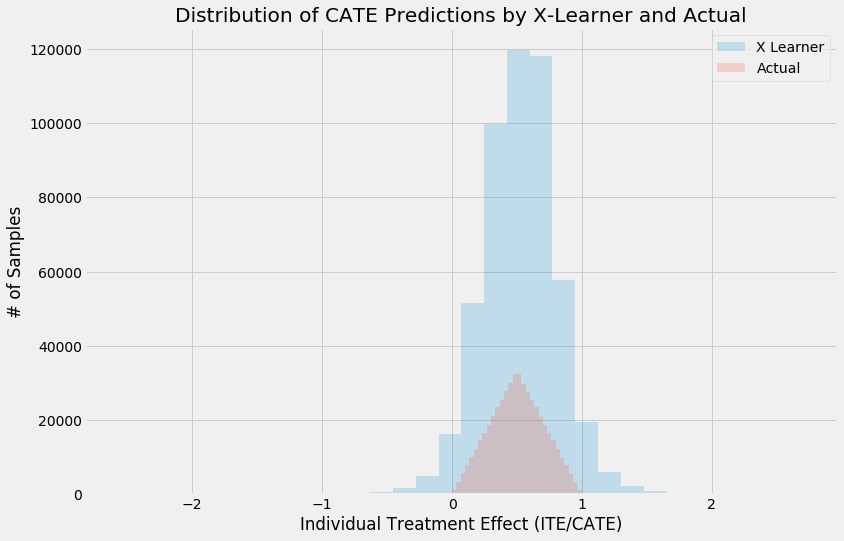

In [14]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [289]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

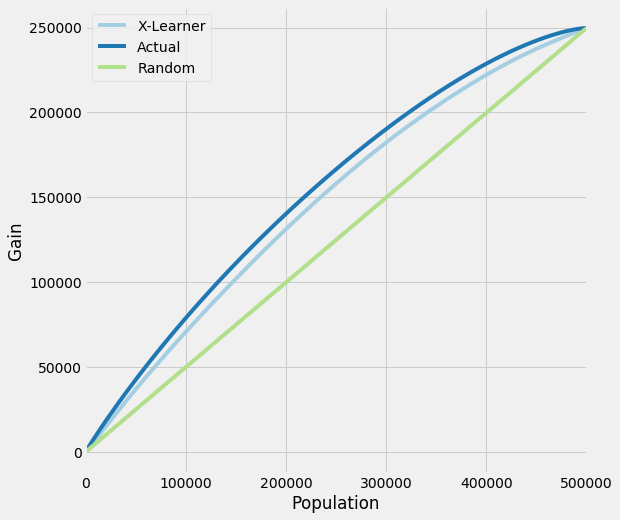

In [292]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

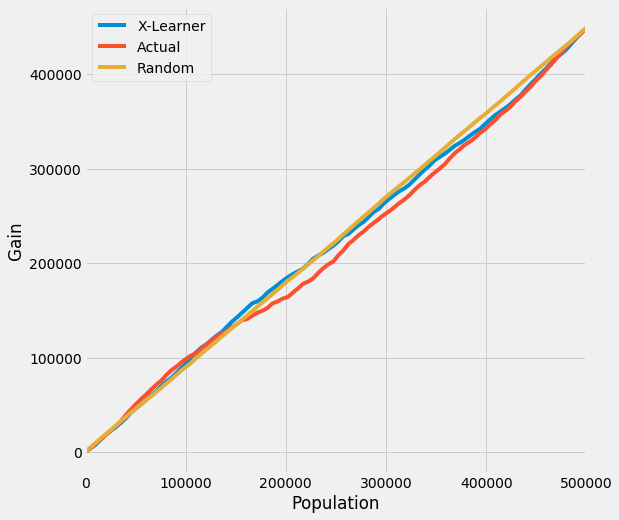

In [17]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

In [18]:
n_fold = 5
n_segment = 5

### TMLE Model Training

In [19]:
kf = KFold(n_splits=n_fold)

In [20]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_all, ate_all_lb, ate_all_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test)

ate_all, ate_all_lb, ate_all_ub

(array([0.49888981]), array([0.46083718]), array([0.53694243]))

In [21]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_actual, ate_actual_lb, ate_actual_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(tau_test, n_segment, labels=False))

ate_actual, ate_actual_lb, ate_actual_ub

(array([[0.24618526, 0.38171264, 0.5201212 , 0.58199463, 0.77109115]]),
 array([[0.15102128, 0.30643768, 0.44998604, 0.49309828, 0.67639516]]),
 array([[0.34134924, 0.45698759, 0.59025636, 0.67089098, 0.86578715]]))

In [22]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(cate_x_test, n_segment, labels=False))

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub

(array([[0.29354514, 0.38265764, 0.50127806, 0.65583362, 0.66551186]]),
 array([[0.20286142, 0.30323476, 0.42064038, 0.56862785, 0.57703147]]),
 array([[0.38422885, 0.46208052, 0.58191573, 0.74303939, 0.75399225]]))

### Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

Text(0,0.5,'Lift in GB')

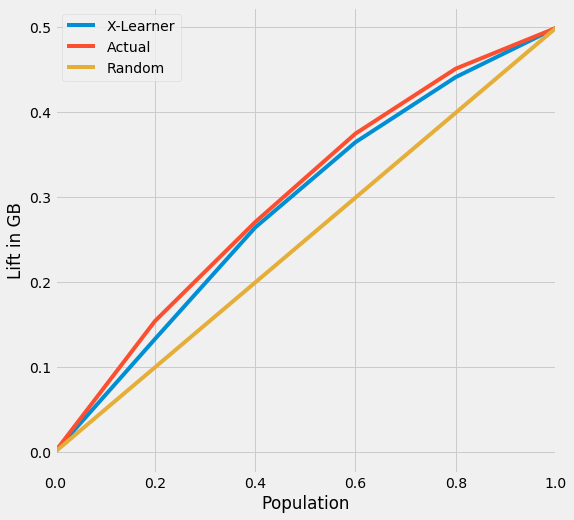

In [23]:
lift_actual = [0.] * (n_segment + 1)
lift_actual[n_segment] = ate_all[0]

lift_xlearner = [0.] * (n_segment + 1)
lift_xlearner[n_segment] = ate_all[0]

for i in range(1, n_segment):
    lift_actual[i] = ate_actual[0][n_segment - i] * .2 + lift_actual[i - 1]
    lift_xlearner[i] = ate_xlearner[0][n_segment - i] * .2 + lift_xlearner[i - 1]     

pd.DataFrame({'Population': np.linspace(0, 1, n_segment + 1),
              'Actual': lift_actual,
              'X-Learner': lift_xlearner,
              'Random': np.linspace(0, 1, n_segment + 1)*lift_actual[-1]}).plot(x='Population', 
                                                                                y=['X-Learner', 'Actual', 'Random'], 
                                                                                figsize=(8, 8))
plt.ylabel('Lift in GB')

### Uplift Curve with TMLE as Ground Truth Direct API Call

In [373]:
# for development purpose
# sys.path.append('../')
# from causalml.metrics.visualize import *

In [298]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [299]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [300]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,5.549587,1,0.900000,0.711159,0.718145,0.458295,0.977994,0.335978,0.986429,0.341892,0.225356,0.516244,0.148062,0.609404,0.786835
1,-4.882516,1,0.900000,0.551081,0.670173,0.571300,0.769047,0.564315,0.972823,0.430016,0.334612,0.010166,0.961719,0.496470,0.753245
2,-3.358887,0,0.468710,0.658303,0.555187,0.164096,0.946278,0.387405,0.145112,0.797590,0.150636,0.896183,0.490697,0.470416,0.250276
3,6.935864,1,0.873329,0.706312,0.819300,0.722882,0.915718,0.476142,0.863175,0.586439,0.576629,0.481607,0.753946,0.701928,0.430092
4,5.370485,1,0.133205,0.368906,0.399929,0.742590,0.057268,0.410999,0.368849,0.647164,0.341280,0.858212,0.814154,0.727759,0.241794


In [301]:
tmle_df = get_tmlelift(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                       inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [302]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.133102,0.154218,0.099778
0.4,0.264269,0.270617,0.199556
0.6,0.364525,0.374641,0.299334
0.8,0.441056,0.450984,0.399112
1.0,0.498890,0.498890,0.498890


#### Uplift Curve

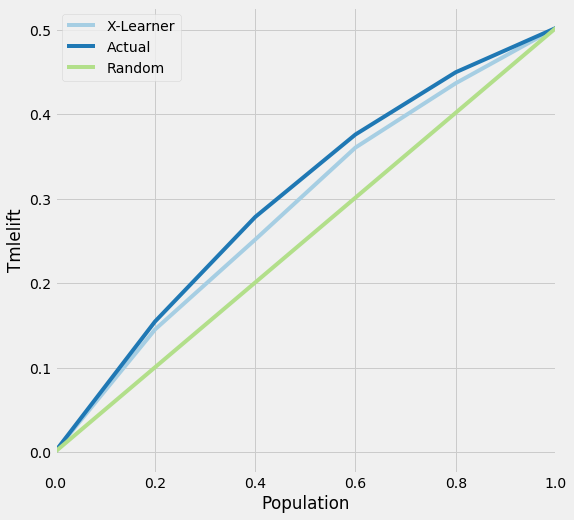

In [203]:
plot_tmlelift(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

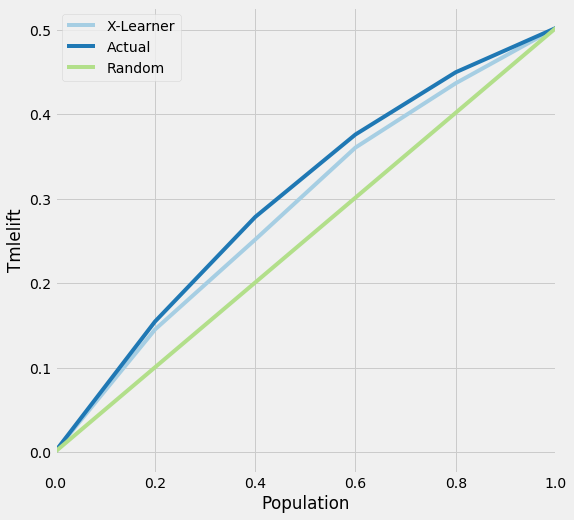

In [196]:
plot(df, kind='tmlelift', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [367]:
auuc_score_tmle(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    0.283640
Actual       0.291558
Random       0.249445
dtype: float64

### Uplift Curve with TMLE as Ground Truth Direct API Call including CI

In [185]:
tmle_df = get_tmlelift(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                   inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                   n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [186]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.145284,0.154755,0.126991,0.135586,0.163577,0.173925,0.100506
0.4,0.251873,0.278635,0.215639,0.241337,0.288108,0.315932,0.201012
0.6,0.360833,0.376327,0.308941,0.325004,0.412725,0.427649,0.301518
0.8,0.437012,0.450038,0.369298,0.383723,0.504726,0.516354,0.402024
1.0,0.502530,0.502530,0.464233,0.464233,0.540828,0.540828,0.502530


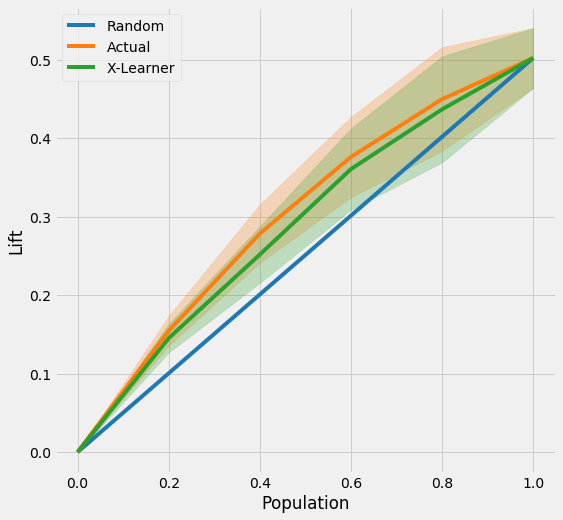

In [175]:
plot_tmlelift(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

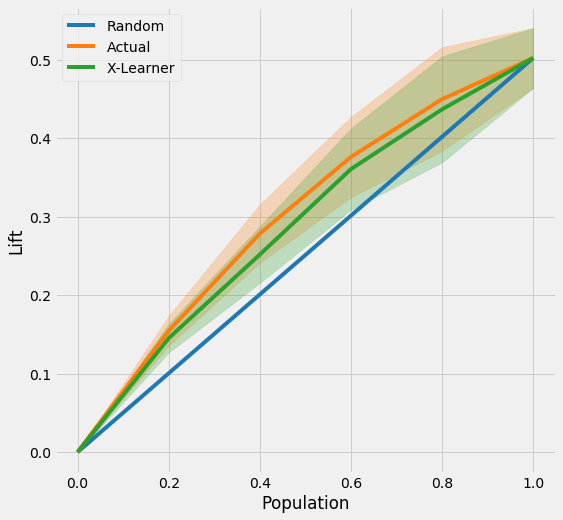

In [182]:
plot(df, kind='tmlelift', ci=True, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True)

### Qini Curve with TMLE as Ground Truth Direct API Call

In [368]:
qini = get_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                    inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [369]:
qini

,X-Learner,Actual,Random
0,0.000000,0.000000,0.00000
1,47934.157471,62802.290174,25839.29909
2,94356.028492,110410.614612,51678.59818
3,122783.507035,136982.566428,77517.89727
4,137401.028863,148805.351980,103357.19636
5,129196.495450,129196.495450,129196.49545


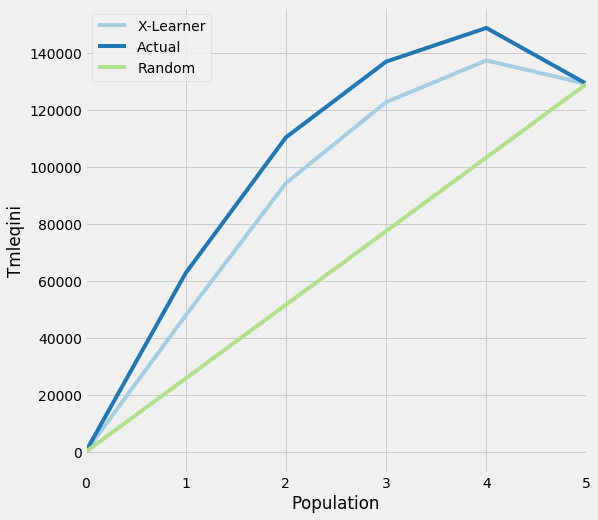

In [370]:
plot_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
              inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

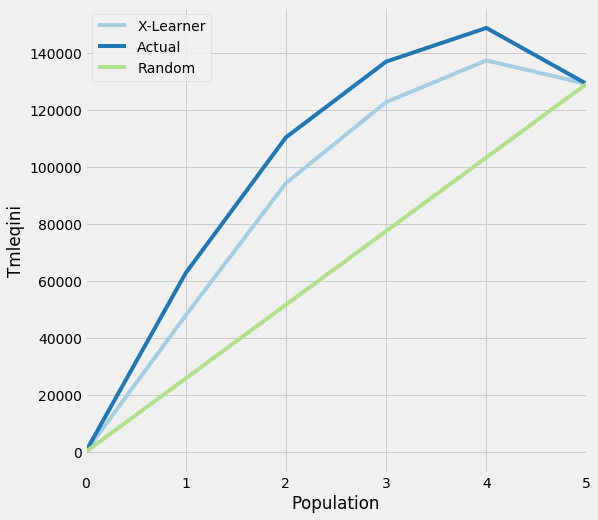

In [371]:
plot(df, kind='tmleqini', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### Qini Score

In [374]:
qini_score_tmle(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    24013.621827
Actual       33434.638716
Random           0.000000
dtype: float64

### Qini Curve with TMLE as Ground Truth Direct API Call including CI

In [376]:
qini = get_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                    inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [377]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,47934.157471,62802.290174,41561.268865,55089.680361,54307.046078,70514.899988,25839.29909
2,94356.028492,110410.614612,81810.454045,95426.105471,106901.602938,125395.123753,51678.59818
3,122783.507035,136982.566428,105664.969943,118414.992228,139902.044127,155550.140628,77517.89727
4,137401.028863,148805.351980,117248.537799,127906.286622,157553.519928,169704.417338,103357.19636
5,129196.495450,129196.495450,129196.495450,129196.495450,129196.495450,129196.495450,129196.49545


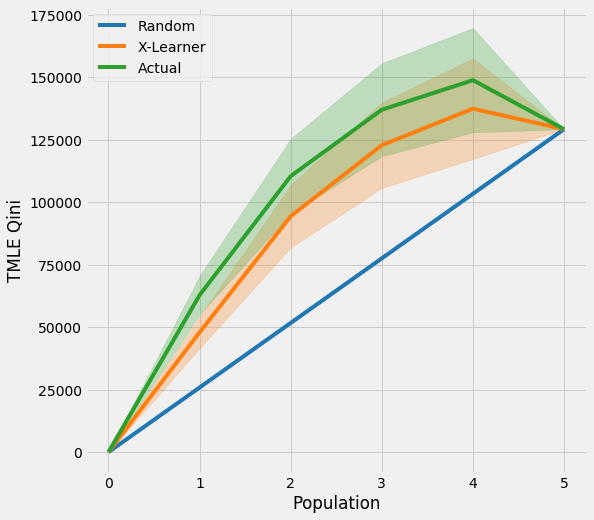

In [378]:
plot_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
              inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

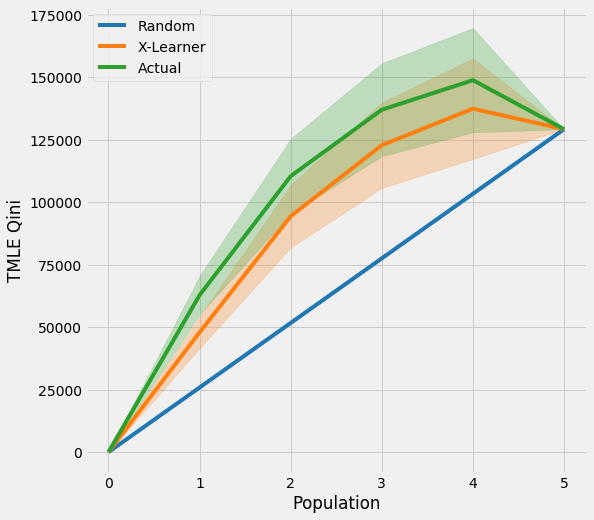

In [379]:
plot(df, kind='tmleqini', ci=True, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True)